#### Create parent folder for custom model training and child folders to store data

In [5]:
# Import the images and the libraries
import shutil # import the shutil module for high-level file operations
shutil.unpack_archive("Images.zip")

In [6]:
import pandas as pd
import os
import cv2 # load the OpenCV (Open Source Computer Vision Library)
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

### Prepare the dataset for model training

In [10]:
#Load and preprocess the data

# Load the labels from labels.csv
labels_df = pd.read_csv('labels.csv', sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']

# Adjust the image IDs in the dataframe
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")
# formats the value x (which should be an integer) into a string that is:
# 08: 8 characters wide.
# 0: Left-padded with zeros if the number is shorter than 8 digits.
# d: Treated as a decimal integer.

# Use iloc to pick the first 1000 labels
labels_df = labels_df.iloc[:1000]

# Load the corresponding images
images_dir = 'Images/'
images = []

# Define target size for images to ensure consistent shape
target_size = (224, 224)

for index, row in labels_df.iterrows():
    img_path = os.path.join(images_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)
    if img is not None:
        # Resize image to a consistent shape before appending
        img = cv2.resize(img, target_size)
        images.append(img)
    else:
        print(f"Error loading image: {img_path}")

images = np.array(images)

# Check if images are loaded
if len(images) == 0:
    print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images)} images loaded successfully.")


1000 images loaded successfully.


In [11]:
# Analyze the distribution of vehicle types in the limited dataset
vehicle_types = labels_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)

# Address data quality issues arising from the discrepancy between labels and actual image filenames
# Sorting the image filenames
labels_df = labels_df.sort_values('image_id')


Distribution of vehicle types:
class
car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: count, dtype: int64


In [12]:
# Redundant code to ensure all images are resized
if len(images) > 0:
    processed_images = [cv2.resize(img, (224, 224)) for img in images]  # Adjust dimensions as needed
    processed_images = np.array(processed_images)
    print("Images resized successfully.")

Images resized successfully.


In [15]:
labels = labels_df['class'].to_numpy()
print("Original labels", labels[:10])
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

# Convert labels to label encoding
unique_labels = np.unique(labels) # identifies all the unique values present in the original labels array
label_to_index = {label: index for index, label in enumerate(unique_labels)} # creates a dictionary that maps each unique label to a new integer index
index_to_label = {index: label for index, label in enumerate(unique_labels)} # creates a reverse mapping dictionary, mapping the new integer indices back to their original label names
labels = np.array([label_to_index[label] for label in labels]) # iterates through the original labels array and replaces each label with its corresponding new integer index

print("Encoded labels",labels[:10])

Original labels ['pickup_truck' 'car' 'car' 'articulated_truck' 'car' 'bus' 'bus' 'car'
 'car' 'car']
Encoded labels [8 3 3 0 3 2 2 3 3 3]


In [16]:
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(processed_images, labels, bounding_boxes, test_size=0.2, random_state=42)
# X_train, X_test are the resulting training and testing sets for processed_images. y_train, y_test are the resulting training and testing sets for labels. bbox_train, bbox_test	are the resulting training and testing sets for bounding_boxes data

#### Create an CNN architecture for object detection

In [17]:
# Model definition
def create_model(input_shape, num_classes): # Defines a multi-task CNN model for both classification and bounding box prediction (The shape of the input images, The number of unique vehicle types/classes to predict)
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs) # first Conv layer
    x = layers.MaxPooling2D((2, 2))(x) # Halves the spatial dimensions (height/width)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x) # second Conv layer
    x = layers.MaxPooling2D((2, 2))(x) # Halves the dimensions again
    x = layers.Conv2D(64, (3, 3), activation='relu')(x) # Third Conv layer
    x = layers.Flatten()(x) # Flattens the 3D feature maps into a 1D vector
    x = layers.Dense(64, activation='relu')(x) # Output layer
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x) # Predicts one of the 'num_classes' vehicle types
    bounding_box = layers.Dense(4, name='bounding_box')(x) # Predicts 4 continuous values (e.g., [x_min, y_min, x_max, y_max])

    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box]) # Assemble the model
    return model

# Model initialization
input_shape = processed_images[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)

# Model compilation
model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

# Model training
model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=100, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - bounding_box_loss: 1769312.8750 - bounding_box_mae: 581.9258 - loss: 1769529.7500 - vehicle_class_accuracy: 0.1588 - vehicle_class_loss: 216.8134 - val_bounding_box_loss: 32800.1367 - val_bounding_box_mae: 137.5711 - val_loss: 31995.5801 - val_vehicle_class_accuracy: 0.0200 - val_vehicle_class_loss: 76.9568
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - bounding_box_loss: 27802.8945 - bounding_box_mae: 129.8877 - loss: 27875.5273 - vehicle_class_accuracy: 0.1521 - vehicle_class_loss: 72.6319 - val_bounding_box_loss: 29842.1035 - val_bounding_box_mae: 124.6441 - val_loss: 29149.4941 - val_vehicle_class_accuracy: 0.6800 - val_vehicle_class_loss: 28.9509
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - bounding_box_loss: 23523.0449 - bounding_box_mae: 116.5216 - loss: 23565.1309 - vehicle_class_accuracy: 0.6354 - vehicle_class_loss: 42.0854 - val_bounding_box_loss: 20759.4062 - val_bounding_box_mae: 110.1447 - val_loss: 2

#### Evaluate the model and check the test results

In [25]:
# Model evaluation
# Trained on 1000 vehicles (i.e. ~ 200 images) so losses are high
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:\nTotal_Loss :',{test_results[0]},'\nvehicle_class_loss :',{test_results[1]}, '\nbounding_box_loss :', {test_results[2]}, '\nbounding_box_mae :', {test_results[3]}, '\nvehicle_class_accuracy :', {test_results[4]})

7/7 - 0s - 20ms/step - bounding_box_loss: 24120.2148 - bounding_box_mae: 113.3475 - loss: 23487.9473 - vehicle_class_accuracy: 0.6300 - vehicle_class_loss: 5.4472

Test results:
Total_Loss : {23487.947265625} 
vehicle_class_loss : {5.4471516609191895} 
bounding_box_loss : {24120.21484375} 
bounding_box_mae : {113.34751892089844} 
vehicle_class_accuracy : {0.6299999952316284}


#### Run inferences on the images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


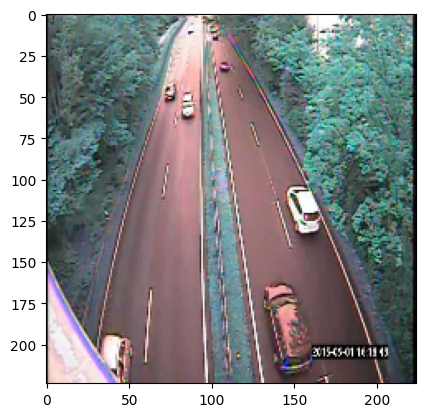

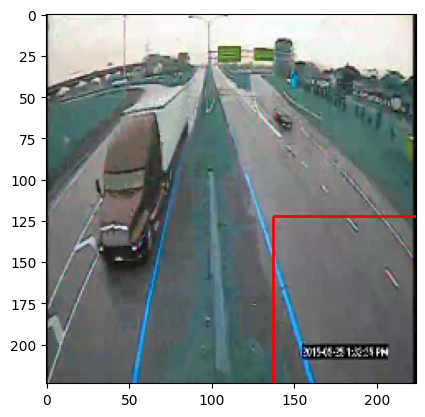

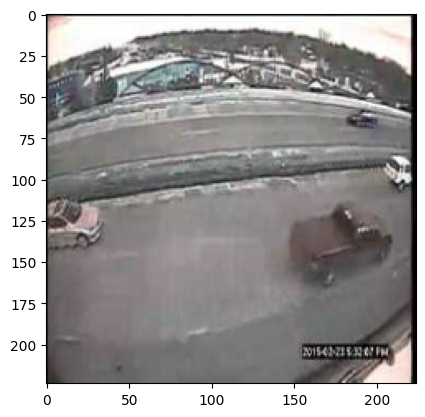

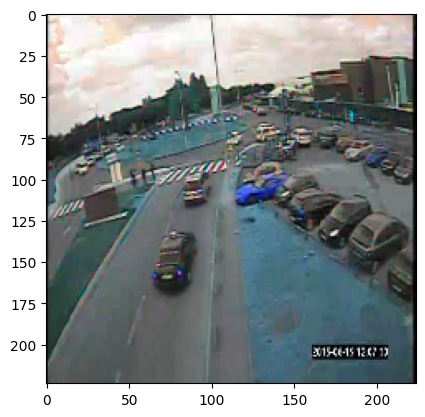

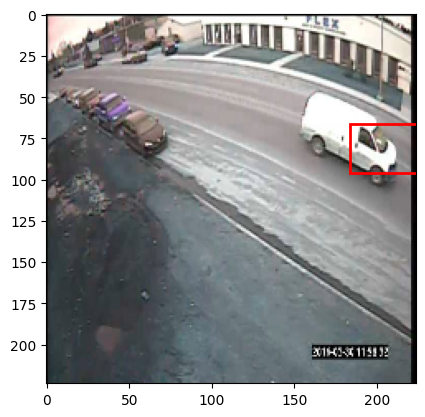

In [26]:
import matplotlib.pyplot as plt

# Choose a few sample images for inference
sample_images = X_test[:5]

# Perform inference on the sample images
predictions = model.predict(sample_images)

# Extract the predicted bounding box coordinates
predicted_bounding_boxes = predictions[1]

# Visualize the sample images with predicted bounding boxes
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                     predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                     predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                     fill=False, edgecolor='r', linewidth=2))
    plt.show()